Etude de cet article : https://arxiv.org/pdf/2006.11209.pdf

Dans un premier temps, on fait les fonctions qui servent à générer des données. Comme dans l'article, on fait un cas linéairement séparable sur la sphère unité. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def sample_Sn(num, dim):
    """
    Sample points uniformly on the sphere
    """
    samples = np.random.normal(size=(num, dim))
    norms = np.linalg.norm(samples, ord=2, axis=1)
    return samples / norms[:, None]

def sample_what(dim):
    return sample_Sn(1, dim).reshape((dim, ))

def get_true_labels(x, what):
    return np.where(x @ what > 0, 1., -1.)

Fonction qui implémentent le NN à une couche cachée

In [3]:
def relu(x):
    return max(0., x)
relu = np.vectorize(relu)

def predict(w, a, x):
    num, dim = x.shape
    M = len(a)
    
    y = relu(w @ x.T / np.sqrt(dim)) # va etre de taille M x num 
    output = a.dot(y) / float(M) # va etre de taille M 
    return output

def unfitted(w, a, x, y):
    preds = predict(w, a, x)
    return np.where(preds * y > 0., 0., 1.)

In [4]:
def average_unfitted(w, a, x, y):
    """
    returns <u(x, y) theta(w.x)yx>_{x, y}
    dimension of the output : (M, dim)
    """
    num, dim = x.shape
    M = len(a)
    predictions = predict(w, a, x)
    unfit = unfitted(w, a, x, y)
    # scalar products between w_i and the x_i (size M * dim)
    scalars = np.where(w.dot(x.T) >= 0., 1., 0.)
    brakets = np.zeros(shape=(M, dim))
    
    for m in range(M):
        brakets[m] = np.average((unfit * y * scalars[m])[:, None] * x, axis = 0)
    
    return brakets

In [5]:
# Rque : cette fonction dans laquelle on calcule les dérivées temporelles des paramètres 
# constitue l'entrainement du modele (via la fonction average_unfitted)

def dynamics(w, a, x, y, beta):
    """
    returns derivative of parameters given dataset
    """
    num, dim = x.shape
    brakets = average_unfitted(w, a, x, y)
    prefactor = beta / np.sqrt(dim)
    a_dot = prefactor * np.diagonal(w @ brakets.T)
    w_dot = prefactor * a[:, None] * brakets
    return a_dot, w_dot

### Evolution des paramètres du réseau

Dans cette partie, on intègre avec Euler explicite l'ODE définie par l'équation (7) de l'article, afin d'obtenir l'évolution de $a$ et $w$ dans le temps. Par simplicité, on prend $\hat{w} = (1, 0, ..., 0)$ (ce que ne devrait rien changer par symmétrie sphérique du problème). 
Ici, on ne prend pas en compte la symmétrie cylindrique des données autour de $\hat{w}$, ni la séparabilité du problème. En effet, dans ce cas la dynamique de $a$ et $w$ peuvent s'écrire de manière explicite via la fonction $\gamma(t)$, dont l'expression dépend de la structure des données, cf equations (13) et (14) de l'article.


**Comparaison des distributions des données** L'équation (10) n'est basée qu'en utilisant la symmétrie cylindrique autour de $\hat{w}$ et sur la séparabilité des variables (= no noise). Ceci implique que la trajectoire est la même pour toutes les données qui suivent la même structure, seule la vitesse le long de cette trajectoire va différer (car paramétrée par $\gamma(t)$)

In [48]:
M = 400
N = 1000
dim = 5

x = sample_Sn(N, dim)
what = np.array([1.] + [0.]*(dim-1))
y = get_true_labels(x, what)

x2 = np.random.normal(size=(N, dim))
y2 = get_true_labels(x2, what)

In [49]:
x_val = sample_Sn(N, dim)
y_val = get_true_labels(x_val, what)

x_val2 = np.random.normal(size=(N, dim))
y_val2 = get_true_labels(x_val2, what)

In [50]:
def train_network(w, a, x, y, T, delta_t, verbose=False):
    w_list, a_list = np.zeros(shape=(T, M, dim)), np.zeros(shape=(T, M))
    w_list[0], a_list[0] = w, a
    debut = time.time()
    for t in range(T-1):
        if t % 100 == 0 and verbose:
            print('t = ', t, '. Elapsed time = ', time.time() - debut)
            debut = time.time()
        a_dot, w_dot = dynamics(w_list[t], a_list[t], x, y, beta=1.0)
        a_list[t+1] = a_list[t] + delta_t * a_dot
        w_list[t+1] = w_list[t] + delta_t * w_dot
    return w_list, a_list

In [51]:
T = 2000
delta_t = 0.1

w, a = np.random.normal(size=(M, dim)), np.random.normal(size=(M,))
w2, a2 = np.random.normal(size=(M, dim)), np.random.normal(size=(M,))

w_list, a_list = train_network(w, a, x, y, T, delta_t, True)
w_list2, a_list2 = train_network(w2, a2, x2, y2, T, delta_t, True)

t =  0 . Elapsed time =  0.0
t =  100 . Elapsed time =  27.537302255630493
t =  200 . Elapsed time =  28.06190037727356
t =  300 . Elapsed time =  27.601131916046143
t =  400 . Elapsed time =  27.489436864852905
t =  500 . Elapsed time =  27.502397060394287
t =  600 . Elapsed time =  29.57086181640625
t =  700 . Elapsed time =  27.950198888778687
t =  800 . Elapsed time =  29.891005516052246
t =  900 . Elapsed time =  29.533387660980225
t =  1000 . Elapsed time =  28.381046533584595
t =  1100 . Elapsed time =  27.297945261001587
t =  1200 . Elapsed time =  27.225139141082764
t =  1300 . Elapsed time =  27.916289567947388
t =  1400 . Elapsed time =  27.5572509765625
t =  1500 . Elapsed time =  27.56223726272583
t =  1600 . Elapsed time =  27.512371063232422
t =  1700 . Elapsed time =  28.14866805076599
t =  1800 . Elapsed time =  28.116754293441772
t =  1900 . Elapsed time =  27.817553520202637
t =  0 . Elapsed time =  0.0
t =  100 . Elapsed time =  27.715827226638794
t =  200 . Elapsed

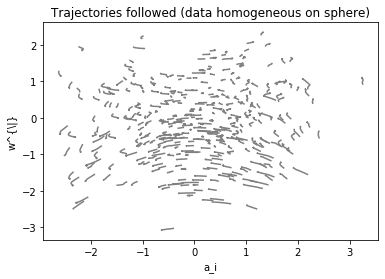

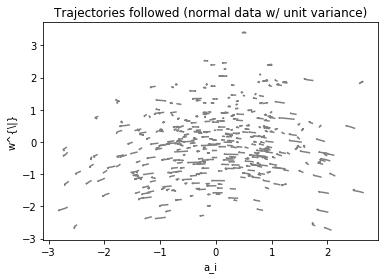

In [56]:
A, W = a_list, w_list
A2, W2 = a_list2, w_list2

for m in range(M):
    plt.plot(A[:, m], W[:, m, 0], '-', color='grey')

plt.xlabel('a_i')
plt.ylabel('w^{\|}')
plt.title('Trajectories followed (data homogeneous on sphere)')
plt.show()

for m in range(M):
    plt.plot(A2[:, m], W2[:, m, 0], '-', color='grey')

plt.xlabel('a_i')
plt.ylabel('w^{\|}')
plt.title('Trajectories followed (normal data w/ unit variance)')
plt.show()

Remarque : ici, l'évolution des paramètres $(a, w)$ semble linéaire : on semble être donc dans un lazy regime

In [54]:
# prend du temps : on évalue chaque version du NN (i.e pour tout t) pour calculer son erreur
# rque : on devrait le faire en même temps que l'entrainement ça prendrait moins de temps

unfits = [unfitted(w_list[t], a_list[t], x, y) for t in range(T)]
unfits_val = [unfitted(w_list[t], a_list[t], x_val, y_val) for t in range(T)]

unfits2 = [unfitted(w_list2[t], a_list2[t], x2, y2) for t in range(T)]
unfits_val2 = [unfitted(w_list2[t], a_list2[t], x_val2, y_val2) for t in range(T)]

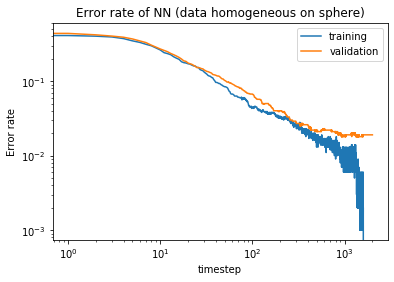

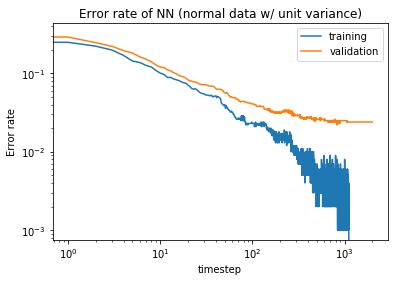

In [57]:
plt.plot(np.mean(unfits, axis=1), label='training')
plt.plot(np.mean(unfits_val, axis=1), label='validation')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Error rate of NN (data homogeneous on sphere)')
plt.xlabel('timestep')
plt.ylabel('Error rate')
plt.show()

# For second dataset

plt.plot(np.mean(unfits2, axis=1), label='training')
plt.plot(np.mean(unfits_val2, axis=1), label='validation')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Error rate of NN (normal data w/ unit variance)')
plt.xlabel('timestep')
plt.ylabel('Error rate')
plt.show()